In [ ]:
# # Spotify Popularity - Neural Network (TensorFlow + KerasTuner)
import warnings
warnings.filterwarnings('ignore')
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # TensorFlow uyarılarını gizle
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
#!pip install keras_tuner
import keras_tuner as kt
RANDOM_STATE = 24
np.random.seed(RANDOM_STATE)
tf.random.set_seed(RANDOM_STATE)
from EngineerFeature import FeatureEngineer

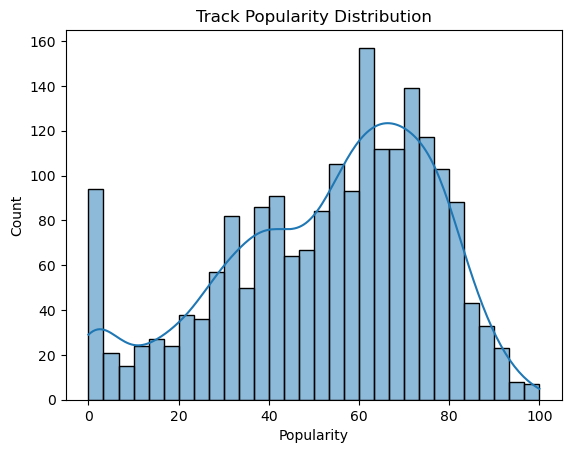

In [64]:
df = pd.read_csv("../final_data.csv")
df = df[:2000]
# y = df["popularity"].values.reshape(-1, 1)

# qt = QuantileTransformer(output_distribution="normal", random_state=42)
# df["popularity"] = qt.fit_transform(y).ravel()
import seaborn as sns
import matplotlib.pyplot as plt
sns.histplot(df['popularity'], bins=30, kde=True)
plt.title("Track Popularity Distribution")
plt.xlabel("Popularity")
plt.ylabel("Count")
plt.show()

In [65]:
X = df.drop("popularity", axis=1)
y = df["popularity"]
print("Features shape:", X.shape)
print("Target shape:", y.shape)

Features shape: (2000, 39)
Target shape: (2000,)


In [66]:
# %%
# Veri bölünmesi: Train (60%) / Val (20%) / Test (20%)
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=RANDOM_STATE
)

# Feature Engineering uygula
fe = FeatureEngineer()
X_temp = fe.fit_transform(X_temp, y_temp)
X_test = fe.transform(X_test)

# Train ve Validation'ı ayır
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp,
    test_size=0.25,  # 0.25 * 0.8 = 0.2 (20% val)
    random_state=RANDOM_STATE
)

print("Train+Val:", X_temp.shape, y_temp.shape, "→ %80 of data")
print("Train:    ", X_train.shape, y_train.shape, "→ %60 of data")
print("Val:      ", X_val.shape,   y_val.shape, "→ %20 of data")
print("Test:     ", X_test.shape,  y_test.shape, "→ %20 of data")


Train+Val: (1600, 42) (1600,) → %80 of data
Train:     (1200, 42) (1200,) → %60 of data
Val:       (400, 42) (400,) → %20 of data
Test:      (400, 42) (400,) → %20 of data


In [67]:
# %%
def build_model(hp: kt.HyperParameters):
    model = keras.Sequential()
    model.add(layers.Input(shape=(42,)))

    # kaç tane hidden layer
    n_layers = hp.Int("n_layers", min_value=2, max_value=5)

    for i in range(n_layers):
        units = hp.Int(f"units_{i}", min_value=32, max_value=256, step=32)
        model.add(layers.Dense(units, activation="relu"))
        model.add(layers.BatchNormalization())
        dropout_rate = hp.Float(f"dropout_{i}", min_value=0.1, max_value=0.3, step=0.1)
        model.add(layers.Dropout(dropout_rate))

    # output layer (regression → 1 nöron)
    model.add(layers.Dense(1, activation="linear"))

    # learning rate
    lr = hp.Float("learning_rate", min_value=1e-4, max_value=1e-3, sampling="log")

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=lr),
        loss=keras.losses.Huber(),
        metrics=["mae"]
    )

    return model

In [68]:
# %%
# Eski tuner loglarını temizle (yeni aramaya başlamak için)
import shutil
import os
if os.path.exists("nn_tuner_logs"):
    shutil.rmtree("nn_tuner_logs")
    print("🗑️ Eski tuner logları silindi, yeni arama başlıyor...")

tuner = kt.BayesianOptimization(
    build_model,
    objective="val_loss",
    max_trials=10,           # 15 farklı kombinasyon deneyecek
    directory="nn_tuner_logs",
    project_name="spotify_popularity_nn",
    overwrite=True           # Eski sonuçların üzerine yaz
)

tuner.search_space_summary()

🗑️ Eski tuner logları silindi, yeni arama başlıyor...
Search space summary
Default search space size: 6
n_layers (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 5, 'step': 1, 'sampling': 'linear'}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 256, 'step': 32, 'sampling': 'linear'}
dropout_0 (Float)
{'default': 0.1, 'conditions': [], 'min_value': 0.1, 'max_value': 0.3, 'step': 0.1, 'sampling': 'linear'}
units_1 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 256, 'step': 32, 'sampling': 'linear'}
dropout_1 (Float)
{'default': 0.1, 'conditions': [], 'min_value': 0.1, 'max_value': 0.3, 'step': 0.1, 'sampling': 'linear'}
learning_rate (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.001, 'step': None, 'sampling': 'log'}


In [69]:
# %%
early_stop = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=20,
    restore_best_weights=True
)

tuner.search(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=200,
    batch_size=32,           # istersen bunu da hp'ye açabiliriz
    callbacks=[early_stop],
    verbose=1
)

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print("Best hyperparameters:", best_hps.values)


Trial 10 Complete [00h 01m 23s]
val_loss: 5.181880950927734

Best val_loss So Far: 4.8774237632751465
Total elapsed time: 00h 06m 01s
Best hyperparameters: {'n_layers': 2, 'units_0': 64, 'dropout_0': 0.2, 'units_1': 224, 'dropout_1': 0.2, 'learning_rate': 0.00028369075342024857, 'units_2': 32, 'dropout_2': 0.2}


In [70]:
# %%
best_model = tuner.hypermodel.build(best_hps)

history = best_model.fit(
    X_temp, y_temp,
    validation_data=(X_test, y_test),
    epochs=200,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 52.4958 - mae: 52.9934 - val_loss: 49.7076 - val_mae: 50.2046
Epoch 2/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 52.1999 - mae: 52.6992 - val_loss: 50.1860 - val_mae: 50.6855
Epoch 3/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 51.9176 - mae: 52.4171 - val_loss: 50.3915 - val_mae: 50.8913
Epoch 4/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 51.5052 - mae: 52.0039 - val_loss: 50.3702 - val_mae: 50.8702
Epoch 5/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 51.0442 - mae: 51.5438 - val_loss: 50.1323 - val_mae: 50.6323
Epoch 6/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 50.4690 - mae: 50.9686 - val_loss: 49.6084 - val_mae: 50.1083
Epoch 7/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 49.7879 - mae: 50.2874 - val_loss: 48.7346 - val_mae: 49.2321
Epoch 8/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 48.8710 - mae: 49.3706 - val_loss: 48.0914 - val_mae: 48.5900
Epoch 9/200
50/50 ━━━━━━━━━━━━━━

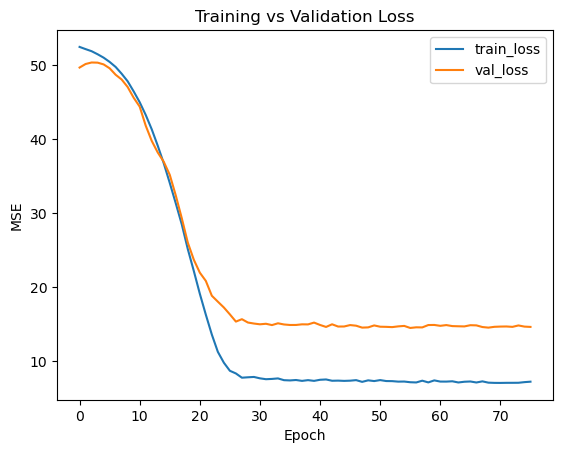

In [78]:
# %%
import matplotlib.pyplot as plt

plt.figure()
plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.legend()
plt.title("Training vs Validation Loss")
plt.show()


In [79]:
# %%
# Test setinde tahmin yap
y_pred_test = best_model.predict(X_test).ravel()

print(f"Tahmin istatistikleri:")
print(f"Min: {y_pred_test.min():.2f}, Max: {y_pred_test.max():.2f}")
print(f"100'ü aşan tahmin sayısı: {(y_pred_test > 100).sum()}")
print(f"0'ın altında tahmin sayısı: {(y_pred_test < 0).sum()}")

# Metrikler
mae  = mean_absolute_error(y_test, y_pred_test)
mse  = mean_squared_error(y_test, y_pred_test)
rmse = np.sqrt(mse)
r2   = r2_score(y_test, y_pred_test)

print("\n=== Test Metrikleri ===")
print(f"MAE  : {mae:.2f}")
print(f"RMSE : {rmse:.2f}")
print(f"MSE  : {mse:.2f}")
print(f"R²   : {r2:.4f}")

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Tahmin istatistikleri:
Min: -20.22, Max: 93.11
100'ü aşan tahmin sayısı: 0
0'ın altında tahmin sayısı: 8

=== Test Metrikleri ===
MAE  : 15.01
RMSE : 20.07
MSE  : 402.74
R²   : 0.2774


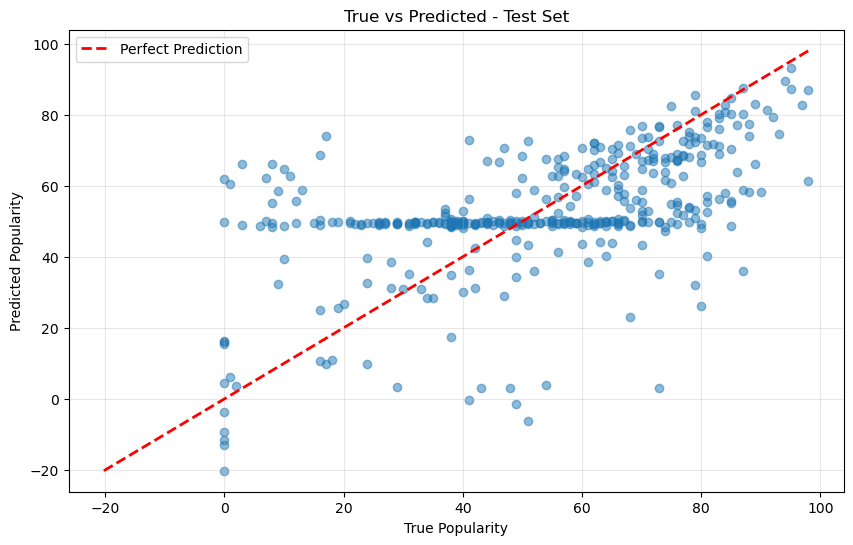

In [80]:
# %%
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_test, alpha=0.5)
plt.xlabel("True Popularity")
plt.ylabel("Predicted Popularity")
plt.title("True vs Predicted - Test Set")
# y=x referans çizgisi
min_val = min(y_test.min(), y_pred_test.min())
max_val = max(y_test.max(), y_pred_test.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect Prediction')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [74]:
# %%
#best_model.save("best_nn_spotify.keras")


In [75]:
# %%
#best_model.save("best_nn_spotify.h5")
